#U-Net Image Segmentation on Oxford-IIIT Pet Dataset (TensorFlow/Keras)
Author: Gorachand  
GitHub: https://github.com/Gorachand2501/unet-image-segmentation

In [3]:
# Import Dependencies
!pip install -q tensorflow tensorflow_datasets matplotlib
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Load the Oxford-IIIT Pet Dataset
print("Loading dataset...")
dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)
train = dataset['train']
test = dataset['test']

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1  # labels: 1 (pet), 2 (background) -> 0,1
    return input_image, input_mask

def load_data(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    return normalize(input_image, input_mask)

train_dataset = train.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)

BATCH_SIZE = 64
train_dataset = train_dataset.cache().shuffle(1000).batch(BATCH_SIZE).repeat()
test_dataset = test_dataset.batch(BATCH_SIZE)

Loading dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.IM5N2M_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.IM5N2M_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


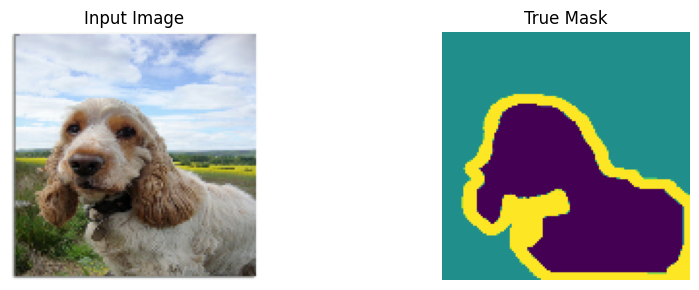

In [8]:
# Visualize Sample Image + Mask
def display_sample(display_list):
    plt.figure(figsize=(10, 3))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.title(title[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

for image, mask in train_dataset.take(1):
    sample_image, sample_mask = image[0], mask[0]
    display_sample([sample_image, sample_mask])

In [9]:
# Define U-Net Architecture
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Encoder
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    # Bottleneck
    x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(x)

    # Decoder
    x = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)

    # Output
    outputs = tf.keras.layers.Conv2D(output_channels, 1, activation='softmax')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [10]:
# Compile the Model
OUTPUT_CLASSES = 3  # pet, background, border (use softmax)
model = unet_model(OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 3)    │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739,843 (2.82 MB)

 Trainable params: 739,843 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the Model
EPOCHS = 10
STEPS_PER_EPOCH = info.splits['train'].num_examples // BATCH_SIZE

print("🚀 Training U-Net...")
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=test_dataset,
                    validation_steps=10)

🚀 Training U-Net...
Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 747s 13s/step - accuracy: 0.5557 - loss: 0.9635 - val_accuracy: 0.5711 - val_loss: 0.8449
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 743s 13s/step - accuracy: 0.6076 - loss: 0.7981 - val_accuracy: 0.6345 - val_loss: 0.7600
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 731s 13s/step - accuracy: 0.6691 - loss: 0.7127 - val_accuracy: 0.7071 - val_loss: 0.6741
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 732s 13s/step - accuracy: 0.7113 - loss: 0.6495 - val_accuracy: 0.6992 - val_loss: 0.6781
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 742s 13s/step - accuracy: 0.7180 - loss: 0.6374 - val_accuracy: 0.7380 - val_loss: 0.6078
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 717s 13s/step - accuracy: 0.7352 - loss: 0.6031 - val_accuracy: 0.7391 - val_loss: 0.6109
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 714s 13s/step - accuracy: 0.7373 - loss: 0.6021 - val_accuracy: 0.7562 - val_loss: 0.5763
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 743s 13s/step - accuracy: 0.7534 - loss: 0.568

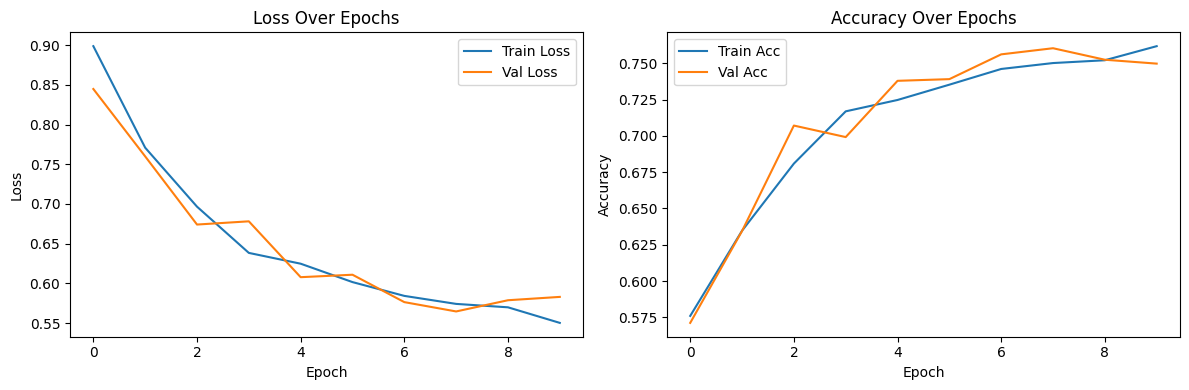

In [12]:
# Plot Loss and Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

🎯 Sample prediction on test data:
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


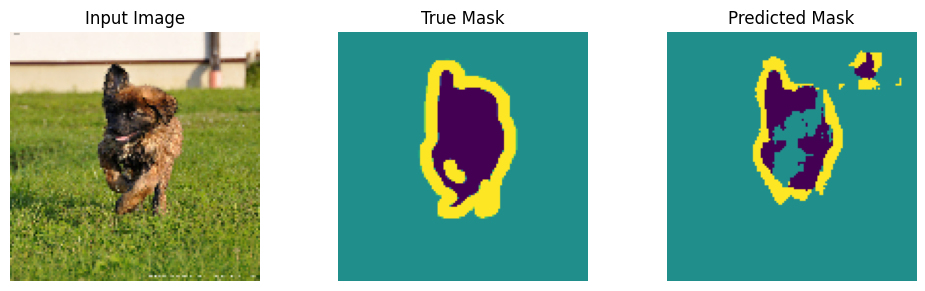

In [13]:
# Predict and Visualize Output
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask[0], create_mask(pred_mask)])
    else:
        pred_mask = model.predict(sample_image[tf.newaxis, ...])
        display_sample([sample_image, sample_mask, create_mask(pred_mask)])

print("🎯 Sample prediction on test data:")
show_predictions(test_dataset, num=1)

In [14]:
# Save the Model
model.save("unet_segmentation_model.keras")
print("✅ Model saved as 'unet_segmentation_model.keras'")

✅ Model saved as 'unet_segmentation_model.keras'
